In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling1D, Flatten, Dropout, BatchNormalization,Softmax, GlobalAveragePooling2D,GlobalMaxPooling2D
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
#import openl3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#EMBEDDINGS CREATION

In [ ]:
#add white noise to the original signal
def noise_addition(data,noise_percentage_factor=0.035):
    noise = np.random.normal(0, data.std(), data.size)
    augmented_data = data + noise * noise_percentage_factor
    return augmented_data

#lower the pitch of the original signal
def pitch_scaling(data, sr, num_semitones=-2):
    return librosa.effects.pitch_shift(data,sr,num_semitones)

#increase the pitch of the original signal
def pitch_scaling2(data, sr, num_semitones=2):
    return librosa.effects.pitch_shift(data,sr,num_semitones)

In [ ]:
#mfccs and deltas extraction
import math

def extract_embeddings(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
    else:
        y,sr=librosa.load(path)
    return y

def extract_embeddings_with_noise(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
        y=noise_addition(y)
    else:
        y,sr=librosa.load(path)
        y=noise_addition(y)
    
    return y


def extract_embeddings_with_pitch_scaling(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
        y=pitch_scaling(y,sr)
    else:
        y,sr=librosa.load(path)
        y=pitch_scaling(y,sr)
    return y

def extract_embeddings_pitch_scaling2(path):
    y, sr = librosa.load(path)
    duration=librosa.get_duration(y=y,sr=sr)
    #reduce the duration of files longer than 3 seconds
    if(duration > 3.0):
        y,sr=librosa.load(path, offset=(duration/2)-1.5 , duration = 3)
        y=pitch_scaling2(y,sr)
    else:
        y,sr=librosa.load(path)
        y=pitch_scaling2(y,sr)
  
    
    return y

In [ ]:
df_noise= pd.read_csv("drive/My Drive/Colab Notebooks/EMOVO/data.csv");

In [ ]:
files_list=[]
for  (index ,path) in zip(df_noise.index,df_noise.file_name):
  files_list.append('drive/My Drive/Colab Notebooks/EMOVO/'+path)

In [ ]:
audio_list=[]
for i in files_list:
  y=extract_embeddings(i)
  y= np.pad(y, create_padding(len(y)), 'constant', constant_values=0)
  audio_list.append(y)

In [ ]:
def create_padding(length):
  diff = 66150 - length
  if diff % 2 == 0:
    return (int(diff/2), int(diff/2))
  else:
    return (int(diff/2) +1 , int(diff/2))

In [ ]:
#extract time series
audio_list_pitch_shifting1=[]
for i in files_list:
    y=extract_embeddings_with_pitch_scaling(i)
    y= np.pad(y, create_padding(len(y)), 'constant', constant_values=0)
    audio_list_pitch_shifting1.append(y)

audio_list_pitch_shifting2=[]
for i in files_list:
    y=extract_embeddings_pitch_scaling2(i)
    y= np.pad(y, create_padding(len(y)), 'constant', constant_values=0)
    audio_list_pitch_shifting2.append(y)

audio_list_noise_addition=[]
for i in files_list:
    y=extract_embeddings_with_noise(i)
    y= np.pad(y, create_padding(len(y)), 'constant', constant_values=0)
    audio_list_noise_addition.append(y)

In [ ]:
#extract embeddings
emb_list_noise, _ = openl3.get_audio_embedding(audio_list_noise_addition, 22050, batch_size=32)

In [ ]:
#create pandas dataframe
for i in range(0,26):
    df["emb"+str(i)]= None
for  (index ,path) in zip(df.index,df.file_name):
        length= len(emb_list[index])
        for i in range(0,length):
            df.at[index, "emb"+str(i)] = emb_list[index][i]
        

In [ ]:
#join the two datasets
frames = [semi_aug_df,noise_df]
aug_df=pd.concat(frames ,ignore_index=True)

In [ ]:
#save dataframe to pickle file
aug_df.to_pickle('drive/My Drive/Colab Notebooks/EMOVO/exploration_df.pkl')

In [ ]:
#read pickle file
from pandas.io.pickle import read_pickle
aug_df=read_pickle('drive/My Drive/Colab Notebooks/EMOVO/exploration_df.pkl')

#DATA VISUALIZATION

In [5]:
#perform TSNE on not augmented data
scaler = StandardScaler()
X_emb = np.array(aug_df.iloc[:, 3:29])
X_emb=X_emb[0:588]
X_emb= np.array(X_emb.tolist())
X_emb=scaler.fit_transform(X_emb.reshape(-1, X_emb.shape[-1])).reshape(X_emb.shape)
X_emb=X_emb.reshape(X_emb.shape[0],X_emb.shape[1]*X_emb.shape[2])
Y_emb=aug_df['label']
tsne = TSNE(2)
tsne_result = tsne.fit_transform(X_emb) 
tsne_df = pd.DataFrame(data=tsne_result , columns=['tsne_1','tsne_2'])
print(tsne_result.shape)

(588, 2)


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

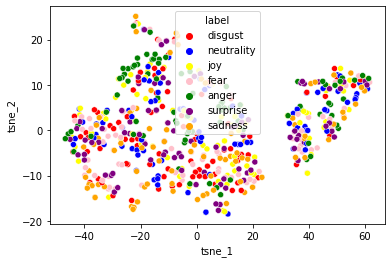

In [7]:
#visualize not augmented data
sns.scatterplot(data=tsne_df, x='tsne_1', y='tsne_2',hue=Y_emb, palette=['red','blue','yellow','pink','green','purple','orange'])  


In [8]:
#perform TSNE on semi augmented data
scaler = StandardScaler()
X_emb = np.array(aug_df.iloc[:, 3:29])
X_emb=X_emb[0:1764]
X_emb= np.array(X_emb.tolist())
X_emb=scaler.fit_transform(X_emb.reshape(-1, X_emb.shape[-1])).reshape(X_emb.shape)
X_emb=X_emb.reshape(X_emb.shape[0],X_emb.shape[1]*X_emb.shape[2])
Y_emb=aug_df['label']
tsne = TSNE(2)
tsne_result = tsne.fit_transform(X_emb) 
tsne_df = pd.DataFrame(data=tsne_result , columns=['tsne_1','tsne_2'])
print(tsne_result.shape)

(1764, 2)


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

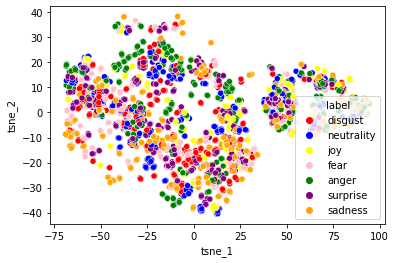

In [9]:
#visualize  semi augmented data
sns.scatterplot(data=tsne_df, x='tsne_1', y='tsne_2',hue=Y_emb, palette=['red','blue','yellow','pink','green','purple','orange']) 

In [10]:
#perform TSNE on semi augmented data
scaler = StandardScaler()
X_emb = np.array(aug_df.iloc[:, 3:29])
X_emb= np.array(X_emb.tolist())
X_emb=scaler.fit_transform(X_emb.reshape(-1, X_emb.shape[-1])).reshape(X_emb.shape)
X_emb=X_emb.reshape(X_emb.shape[0],X_emb.shape[1]*X_emb.shape[2])
Y_emb=aug_df['label']
tsne = TSNE(2)
tsne_result = tsne.fit_transform(X_emb) 
tsne_df = pd.DataFrame(data=tsne_result , columns=['tsne_1','tsne_2'])
print(tsne_result.shape)

(2352, 2)


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

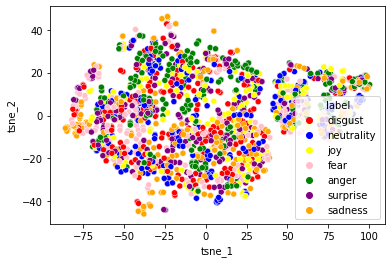

In [11]:
#visualize  augmented data
sns.scatterplot(data=tsne_df, x='tsne_1', y='tsne_2',hue=Y_emb, palette=['red','blue','yellow','pink','green','purple','orange'])  


#LEAVE-ONE-SPEAKER-OUT AND GENRE BASED VALIDATION USING THE EMBEDDINGS

In [ ]:
#encode the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(aug_df['label'])
aug_df['label_id']=le.transform(aug_df['label'])

In [ ]:
#extraction of labels_id from datasets
Y_aug=aug_df['label_id']

In [ ]:
X_aug = np.array(aug_df.loc[:, ['emb' in i for i in aug_df.columns]])
X_aug=np.array(X_aug.tolist())
X_aug= np.reshape(X_aug, (X_aug.shape[0],X_aug.shape[1],X_aug.shape[2],1))

In [ ]:
def create_loso_generator(df,actor):
  train_data=df.index[df['actor'] != actor]
  test_data=df.index[df['actor'] == actor]
  return train_data,test_data

In [ ]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()


  modelcnn.add(keras.layers.Conv2D(32, (2, 6), activation='relu', input_shape=input_data,kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7), strides=(2,2),padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))
  
  modelcnn.add(keras.layers.Conv2D(64, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(128, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(256, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))

 

  

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))
  modelcnn.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

In [ ]:
input_data=(X_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
actors=['f1','f2','f3','m1','m2','m3']
for i in tqdm(actors,total=6, leave=False,desc="Computing k-fold"):
  train_indices,test_indices= create_loso_generator(aug_df,i)
  # get the training and test data
  train_X, test_X = X_aug[train_indices], X_aug[test_indices]
  train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
  aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
  #normalize the data
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
  test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
  print(train_X.shape)
  modelcnn=create_cnn(input_data)
  modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=64,epochs=1000,callbacks=[EarlyStopping(patience=30,monitor="loss")])
  aug_histories_cnn.append(history)
  pred=modelcnn.predict(test_X)
  pred=pred.argmax(axis=1)
  aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
  conf_matr=confusion_matrix(test_y,pred)
  aug_confusion_matrices_cnn.append(conf_matr)
  results = modelcnn.evaluate(test_X, test_y, batch_size=128)
  aug_results_cnn.append({i: results})

Computing k-fold:   0%|          | 0/6 [00:00<?, ?it/s]

(1960, 26, 6144, 1)
Epoch 1/1000
31/31 [==============================] - 39s 707ms/step - loss: 2.4125 - accuracy: 0.1413 - val_loss: 2.3349 - val_accuracy: 0.1429
Epoch 2/1000
31/31 [==============================] - 19s 609ms/step - loss: 2.2925 - accuracy: 0.1444 - val_loss: 2.2502 - val_accuracy: 0.1429
Epoch 3/1000
31/31 [==============================] - 19s 601ms/step - loss: 2.2192 - accuracy: 0.1510 - val_loss: 2.1883 - val_accuracy: 0.1429
Epoch 4/1000
31/31 [==============================] - 18s 581ms/step - loss: 2.1652 - accuracy: 0.1454 - val_loss: 2.1422 - val_accuracy: 0.1429
Epoch 5/1000
31/31 [==============================] - 18s 579ms/step - loss: 2.1232 - accuracy: 0.1444 - val_loss: 2.1059 - val_accuracy: 0.1429
Epoch 6/1000
31/31 [==============================] - 19s 605ms/step - loss: 2.0901 - accuracy: 0.1551 - val_loss: 2.0810 - val_accuracy: 0.1429
Epoch 7/1000
31/31 [==============================] - 19s 608ms/step - loss: 2.0708 - accuracy: 0.1388 - val_l

KeyboardInterrupt: ignored

In [ ]:
def genre_generator(df,genre):
  if genre=="male":
      train_data=df.index[(df['actor'] == 'm1') | (df['actor'] == 'm2')| (df['actor'] == 'm3')]
      test_data=df.index[(df['actor'] == 'f1') | (df['actor'] == 'f2') | (df['actor'] == 'f3')]
      return train_data,test_data
  else:
      train_data=df.index[(df['actor'] == 'f1') | (df['actor'] == 'f2') | (df['actor'] == 'f3')]
      test_data=df.index[(df['actor'] == 'm1') | (df['actor'] == 'm2') | (df['actor'] == 'm3')]
      return train_data,test_data


In [ ]:
def male_generator(df,actor):
  train_data=df.index[(df['actor'] != actor) & (df['actor'] != 'f1') & (df['actor'] != 'f2') & (df['actor'] != 'f3')]
  test_data=df.index[df['actor'] == actor]
  return train_data,test_data
  

In [ ]:
def female_generator(df,actor):
  train_data=df.index[(df['actor'] != actor) & (df['actor'] != 'm1') & (df['actor'] != 'm2') & (df['actor'] != 'm3')]
  test_data=df.index[df['actor'] == actor]
  return train_data,test_data

In [ ]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()


  modelcnn.add(keras.layers.Conv2D(32, (2, 6), activation='relu', input_shape=input_data,kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7), strides=(2,2),padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))
  
  modelcnn.add(keras.layers.Conv2D(64, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2,7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(128, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(256, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))
  modelcnn.add(keras.layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

In [ ]:
input_data=(X_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
genres=['male','female']
for i in tqdm(genres,total=2, leave=False,desc="Computing genres"):
  train_indices,test_indices= genre_generator(aug_df,i)
  # get the training and test data
  train_X, test_X = X_aug[train_indices], X_aug[test_indices]
  train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
  aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
  #normalize the data
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
  test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
  print(train_X.shape)
  modelcnn=create_cnn(input_data)
  modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=128,epochs=1000,callbacks=[EarlyStopping(patience=30,monitor="loss")])
  aug_histories_cnn.append(history)
  pred=modelcnn.predict(test_X)
  pred=pred.argmax(axis=1)
  aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
  conf_matr=confusion_matrix(test_y,pred)
  aug_confusion_matrices_cnn.append(conf_matr)
  results = modelcnn.evaluate(test_X, test_y, batch_size=128)
  aug_results_cnn.append({i: results})

Computing genres:   0%|          | 0/2 [00:00<?, ?it/s]

(1176, 26, 6144, 1)
Epoch 1/1000
10/10 [==============================] - 35s 2s/step - loss: 2.6216 - accuracy: 0.1378 - val_loss: 2.5315 - val_accuracy: 0.1429
Epoch 2/1000
10/10 [==============================] - 13s 1s/step - loss: 2.5074 - accuracy: 0.1386 - val_loss: 2.4729 - val_accuracy: 0.1429
Epoch 3/1000
10/10 [==============================] - 13s 1s/step - loss: 2.4507 - accuracy: 0.1361 - val_loss: 2.4189 - val_accuracy: 0.1429
Epoch 4/1000
10/10 [==============================] - 13s 1s/step - loss: 2.3986 - accuracy: 0.1352 - val_loss: 2.3714 - val_accuracy: 0.1429
Epoch 5/1000
10/10 [==============================] - 13s 1s/step - loss: 2.3555 - accuracy: 0.1454 - val_loss: 2.3300 - val_accuracy: 0.1429
Epoch 6/1000
10/10 [==============================] - 13s 1s/step - loss: 2.3151 - accuracy: 0.1454 - val_loss: 2.2941 - val_accuracy: 0.1429
Epoch 7/1000
10/10 [==============================] - 13s 1s/step - loss: 2.2816 - accuracy: 0.1190 - val_loss: 2.2626 - val_acc

KeyboardInterrupt: ignored